# Daily Smoke and Asthma Place of Service Analysis <a class="tocSkip">

**Author: Ryan Gan**

**Date Created: 2018-08-12**

Daily time series analysis evaluating the impact of wildfire smoke in Medford on asthma-related claims and pharmacy. 

Loading tidyverse.

In [1]:
# load tidyverse
library(tidyverse)
library(splines)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.3.0     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::vars()    masks ggplot2::vars()


## Health Outcomes and Smoke Descriptives

Reading in asthma care time series for each metro area from 2013-05-01 to 2013-09-30.

In [2]:
# load time series
asthma_msa_ts <- read_csv('../../data/health/2013-asthma_msa_smk.csv') %>% 
    # create binary classifiers
    mutate(smk5 = ifelse(avg_smk_pm > 5, 1, 0), 
           smk10 = ifelse(avg_smk_pm > 10, 1, 0), 
           smk15 = ifelse(avg_smk_pm > 15, 1, 0)) 

Parsed with column specification:
cols(
  date = col_date(format = ""),
  metroarea = col_character(),
  service_place = col_character(),
  n_events = col_integer(),
  pop = col_integer(),
  avg_smk_pm = col_double(),
  avg_temp = col_double(),
  day = col_character(),
  weekend = col_integer(),
  month = col_integer()
)


Subset to one outcome to plot time series of PM<sub>2.5</sub>.

In [3]:
smk_ts <- asthma_msa_ts %>% 
    filter(service_place == 'Office') %>% 
    select(-service_place, -n_events, -pop) %>% 
    arrange(metroarea, date) %>% 
    mutate(pm_type = 'GWR PM')

In [4]:
glimpse(smk_ts)

Observations: 849
Variables: 11
$ date       <date> 2013-05-01, 2013-05-02, 2013-05-03, 2013-05-04, 2013-05...
$ metroarea  <chr> "Bend", "Bend", "Bend", "Bend", "Bend", "Bend", "Bend", ...
$ avg_smk_pm <dbl> 1.734179e-03, 6.551992e-03, 1.710610e-02, 0.000000e+00, ...
$ avg_temp   <dbl> 279.5387, 284.8179, 284.1024, 283.0617, 285.2135, 286.49...
$ day        <chr> "Wed", "Thu", "Fri", "Sat", "Sun", "Mon", "Tue", "Wed", ...
$ weekend    <int> 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,...
$ month      <int> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...
$ smk5       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ smk10      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ smk15      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pm_type    <chr> "GWR PM", "GWR PM", "GWR PM", "GWR PM", "GWR PM", "GWR P...


### Time Series Plot of MSA PM<sub>2.5</sub> 

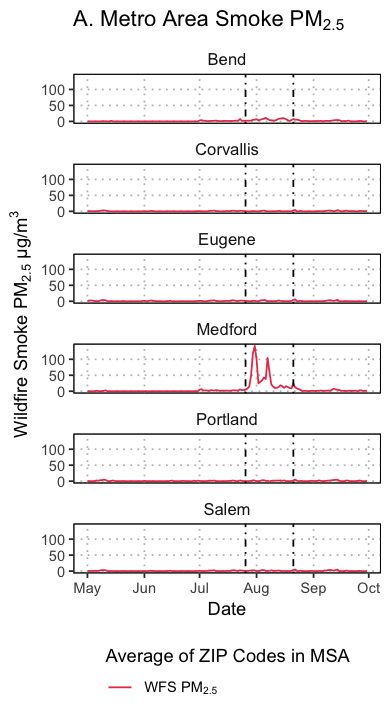

In [5]:
# set plot options
options(repr.plot.width = 3.25, repr.plot.height = 6)

# plot of pm by msa
pm_msa_plot <- ggplot(data = smk_ts, aes(x = date, y = avg_smk_pm, color = pm_type)) +
    geom_line() + 
    scale_color_manual(name = 'Average of ZIP Codes in MSA',
                       labels = expression(paste('WFS PM'[2.5])), 
                       values = '#e94057',
                       guide = guide_legend(title.position = 'top')) +
    # facet by metro area
    facet_wrap(~metroarea, ncol=1) +
    # verticle line for smoke impacted period
    geom_vline(data = smk_ts, aes(xintercept=as.numeric(date[79])), linetype = 'dotdash') +
    geom_vline(data = smk_ts, aes(xintercept=as.numeric(date[99])), linetype = 'dotdash') +
    # y label
    ylab(expression(paste("Wildfire Smoke PM"[2.5]," µg/m"^3))) +
    # x label
    xlab("Date") +
    ggtitle(expression(paste('A. Metro Area Smoke PM'[2.5]))) +
    theme(panel.background = element_rect(fill = 'white', colour = 'black'),
        panel.grid.major = element_line(color = 'grey', linetype = 'dotted',
                                        size = 0.5),
        panel.grid.minor = element_blank(),
        # strip element
        strip.background = element_rect(colour=NA, fill=NA),
        panel.border = element_rect(fill = NA, color = "black"),
        # facet text size
        strip.text = element_text(size = 10),
        axis.title.y = element_text(angle = 90),
        legend.position = 'bottom',
        legend.key = element_rect(fill = NA, colour = NA, size = 0.25))

pm_msa_plot

Table of counts of binary smoke days. 

In [6]:
# smoke classification
smoke_counts <- asthma_msa_ts %>%
    # filter to one place of service to not double count
    filter(service_place == 'Office') %>% 
    group_by(metroarea) %>% 
    summarize(n = n(), smk5_n = sum(smk5), smk10_n = sum(smk10), smk15_n = sum(smk15))

smoke_counts

metroarea,n,smk5_n,smk10_n,smk15_n
Bend,136,16,1,0
Corvallis,118,0,0,0
Eugene,145,1,0,0
Medford,144,32,22,15
Portland,153,0,0,0
Salem,153,0,0,0


### Time Series Plots of Health Outcomes for All MSAs

Aggregated plots of outcomes for all MSAs in Oregon. Trying to get a general idea of temporal trends.

Plot of Oregon aggregated rate per 100k persons for each outcome and Medford-specific rate.

In [7]:
# aggergate oregon 
oregon_aggregate <- asthma_msa_ts %>% 
    # filter out ambulance visits
    filter(service_place != 'Ambulance') %>% 
    # group by date
    group_by(date, service_place) %>% 
    # summarize counts and population
    summarize(n_events = sum(n_events), pop = sum(pop)) %>% 
    # create variables
    mutate(rate = n_events/pop, 
           rate_100k = rate*100000, 
           day = lubridate::wday(date, label = TRUE), 
           weekend = ifelse(day %in% c('Sat', 'Sun'), 1, 0)) %>% 
    arrange(service_place, date)

In [8]:
head(oregon_aggregate)

date,service_place,n_events,pop,rate,rate_100k,day,weekend
2013-05-01,Emergency Department,13,3434718,3.784881e-06,0.3784881,Wed,0
2013-05-02,Emergency Department,11,2829600,3.887475e-06,0.3887475,Thu,0
2013-05-03,Emergency Department,11,2914407,3.774353e-06,0.3774353,Fri,0
2013-05-04,Emergency Department,19,3062293,6.204501e-06,0.6204501,Sat,1
2013-05-05,Emergency Department,15,3269448,4.587930e-06,0.4587930,Sun,1
2013-05-06,Emergency Department,10,2707252,3.693782e-06,0.3693782,Mon,0


In [9]:
# spline fits
oregon_estimates <- oregon_aggregate %>% 
    split(.$service_place) %>% 
    map_dfr(function(df){
        # run with interaction if saba fill, office, or outpatient
        if (df[1,]$service_place %in% c('SABA Fill', 'Office', 'Outpatient Hospital'))
            {
            spl <- ns(df$date, df = 3)
            mod <- glm(n_events ~ weekend*spl + offset(log(pop)), data = df, family = 'quasipoisson'(link='log'))
            pred <- predict(mod, type = 'response', se.fit = TRUE, interval="confidence", level = 0.95)
            return_df <- tibble(pred$fit, pred$se.fit) %>% rename(pred_n = 'pred$fit', se = 'pred$se.fit')
            } else { # else run without interaction 
            spl <- ns(df$date, df = 3)
            mod <- glm(n_events ~ spl + offset(log(pop)), data = df, family = 'quasipoisson'(link='log'))
            pred <- predict(mod, type = 'response', se.fit = TRUE, interval="confidence", level = 0.95)
            return_df <- tibble(pred$fit, pred$se.fit) %>% rename(pred_n = 'pred$fit', se = 'pred$se.fit')    
            }
        })

# bind cols to oregon aggregate
oregon_asthma_rates <- bind_cols(oregon_aggregate, oregon_estimates) %>% 
    mutate(pred_rate = (pred_n/pop)*100000, 
           se_rate = (se/pop)*100000,
           weekend_pred = ifelse(service_place %in% c('SABA Fill', 'Office', 'Outpatient Hospital'), weekend, 0))

In [10]:
summary(as.factor(oregon_asthma_rates$weekend_pred))

0   1 
779 132

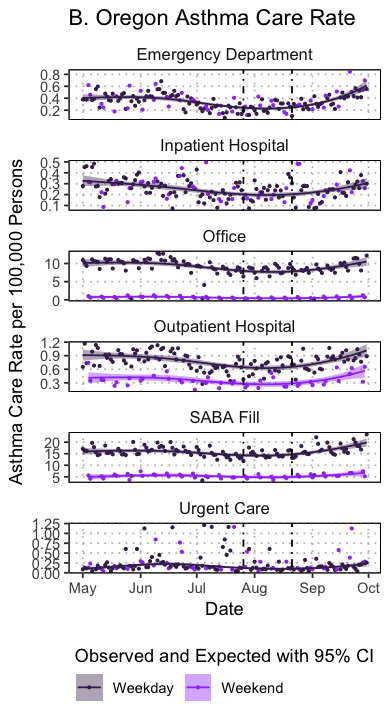

In [11]:
# set plot options
options(repr.plot.width = 3.25, repr.plot.height = 6)

# plot of pm by msa
asthma_oregon_plot <- ggplot() +
    # observed
    geom_point(data = oregon_asthma_rates, 
               aes(x=date, y=rate_100k, group = weekend, color=as.factor(weekend)),
               size = 0.5) +
    # expected
    geom_line(data = oregon_asthma_rates,
              aes(x = date, y = pred_rate, group = weekend_pred, color = as.factor(weekend_pred))) + #, color='#da22ff') +
    geom_ribbon(data = oregon_asthma_rates,
                aes(x = date,
                    ymin = (pred_rate - 1.96*se_rate), 
                    ymax = (pred_rate + 1.96*se_rate), 
                    group = weekend_pred, fill = as.factor(weekend_pred)), alpha = 0.4) +
    scale_color_manual(name = 'Observed and Expected with 95% CI',
                       labels = c('Weekday', 'Weekend'),
                       values = c('#41295a', '#a044ff'), 
                       guide = guide_legend(title.position = 'top')) +
    scale_fill_manual(name = 'Observed and Expected with 95% CI',
                      labels = c('Weekday', 'Weekend'),
                      values = c('#41295a', '#a044ff')) +
    # facet by metro area
    facet_wrap(~service_place, scales = 'free_y', ncol=1) +
    # verticle line for smoke impacted period
    geom_vline(data = smk_ts, aes(xintercept=as.numeric(date[79])), linetype = 'dotdash') +
    geom_vline(data = smk_ts, aes(xintercept=as.numeric(date[99])), linetype = 'dotdash') +
    # y label
    ylab('Asthma Care Rate per 100,000 Persons') +
    # x label
    xlab("Date") +
    ggtitle('B. Oregon Asthma Care Rate') +
    theme(panel.background = element_rect(fill = 'white', colour = 'black'),
        panel.grid.major = element_line(color = 'grey', linetype = 'dotted',
                                        size = 0.5),
        panel.grid.minor = element_blank(),
        # strip element
        strip.background = element_rect(colour=NA, fill=NA),
        panel.border = element_rect(fill = NA, color = "black"),
        # facet text size
        strip.text = element_text(size = 10),
        axis.title.y = element_text(angle = 90),
        legend.position = 'bottom',
        legend.key = element_rect(fill = NA, colour = NA, size = 0.25))

asthma_oregon_plot

In [12]:
# medford-specific timeseries
medford <- asthma_msa_ts %>% 
    # filter out ambulance visits
    filter(metroarea == 'Medford') %>% 
    filter(service_place != 'Ambulance') %>% 
    # calculate rates
    mutate(rate = n_events/pop, 
           rate_100k = rate*100000) %>% 
    dplyr::select(date, service_place, n_events, pop, rate, rate_100k, day, weekend) %>% 
    arrange(service_place, date)

In [13]:
# spline fits
medford_estimates <- medford %>% 
    split(.$service_place) %>% 
    map_dfr(function(df){
        # run with interaction if saba fill, office, or outpatient
        if (df[1,]$service_place %in% c('SABA Fill', 'Office'))
            {
            spl <- ns(df$date, df = 3)
            mod <- glm(n_events ~ weekend*spl + offset(log(pop)), data = df, family = 'quasipoisson'(link='log'))
            pred <- predict(mod, type = 'response', se.fit = TRUE, interval="confidence", level = 0.95)
            return_df <- tibble(pred$fit, pred$se.fit) %>% rename(pred_n = 'pred$fit', se = 'pred$se.fit')
            } else { # else run without interaction 
            spl <- ns(df$date, df = 3)
            mod <- glm(n_events ~ spl + offset(log(pop)), data = df, family = 'quasipoisson'(link='log'))
            pred <- predict(mod, type = 'response', se.fit = TRUE, interval="confidence", level = 0.95)
            return_df <- tibble(pred$fit, pred$se.fit) %>% rename(pred_n = 'pred$fit', se = 'pred$se.fit')    
            }
        })

# bind cols to oregon aggregate
medford_asthma_rates <- bind_cols(medford, medford_estimates) %>% 
    mutate(pred_rate = (pred_n/pop)*100000, 
           se_rate = (se/pop)*100000,
           weekend_pred = ifelse(service_place %in% c('SABA Fill', 'Office'), weekend, 0))

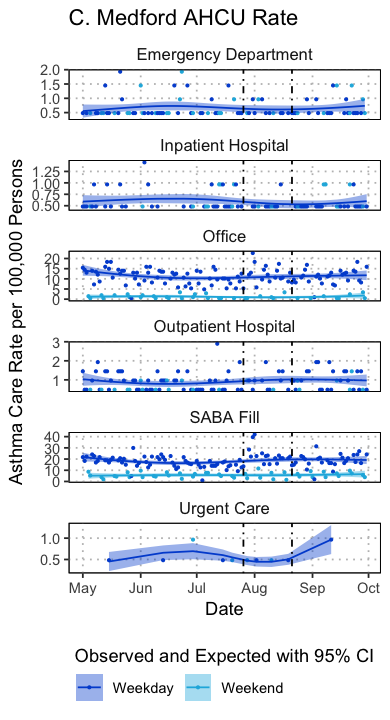

In [14]:
# set plot options
options(repr.plot.width = 3.25, repr.plot.height = 6)

# plot of pm by msa
med_oregon_plot <- ggplot() +
    # observed
    geom_point(data = medford_asthma_rates, 
               aes(x=date, y=rate_100k, group = weekend, color=as.factor(weekend)),
               size = 0.5) +
    # expected
    geom_line(data = medford_asthma_rates,
              aes(x = date, y = pred_rate, group = weekend_pred, color = as.factor(weekend_pred))) + #, color='#da22ff') +
    geom_ribbon(data = medford_asthma_rates,
                aes(x = date,
                    ymin = (pred_rate - 1.96*se_rate), 
                    ymax = (pred_rate + 1.96*se_rate), 
                    group = weekend_pred, fill = as.factor(weekend_pred)), alpha = 0.4) +
    scale_color_manual(name = 'Observed and Expected with 95% CI',
                       labels = c('Weekday', 'Weekend'),
                       values = c('#0052D4', '#1cb5e0'), 
                       guide = guide_legend(title.position = 'top')) +
    scale_fill_manual(name = 'Observed and Expected with 95% CI',
                      labels = c('Weekday', 'Weekend'),
                      values = c('#0052D4', '#1cb5e0')) +
    # facet by metro area
    facet_wrap(~service_place, scales = 'free_y', ncol=1) +
    # verticle line for smoke impacted period
    geom_vline(data = smk_ts, aes(xintercept=as.numeric(date[79])), linetype = 'dotdash') +
    geom_vline(data = smk_ts, aes(xintercept=as.numeric(date[99])), linetype = 'dotdash') +
    # y label
    ylab('Asthma Care Rate per 100,000 Persons') +
    # x label
    xlab("Date") +
    ggtitle('C. Medford AHCU Rate') +
    theme(panel.background = element_rect(fill = 'white', colour = 'black'),
        panel.grid.major = element_line(color = 'grey', linetype = 'dotted',
                                        size = 0.5),
        panel.grid.minor = element_blank(),
        # strip element
        strip.background = element_rect(colour=NA, fill=NA),
        panel.border = element_rect(fill = NA, color = "black"),
        # facet text size
        strip.text = element_text(size = 10),
        axis.title.y = element_text(angle = 90),
        legend.position = 'bottom',
        legend.key = element_rect(fill = NA, colour = NA, size = 0.25))

med_oregon_plot

In [15]:
# final plot
png('./Figs/msa_smoke_asthma.png', width = 800, height = 700)
options(repr.plot.width = 10, repr.plot.height = 8)
gridExtra::grid.arrange(pm_msa_plot, asthma_oregon_plot, med_oregon_plot, ncol=3, widths = c(1,1,1))
dev.off()

pdf 
  2

## Absolute Difference Time Series Analysis for Medford

This model estimates the average difference in counts on days when there was smoke vs. non-smoke, adjusting for seasonal and weekend variation.

I can make a strong argument that really only Medford was affected by wildfire smoke during this time period. Analysis of the effect of smoke on outcomes. I'm going to limit to Medford and SABA counts to figure out an approach.

In [16]:
saba_medford <- filter(asthma_msa_ts, service_place == 'SABA Fill' & metroarea == 'Medford')

Plot of Medford SABA counts.

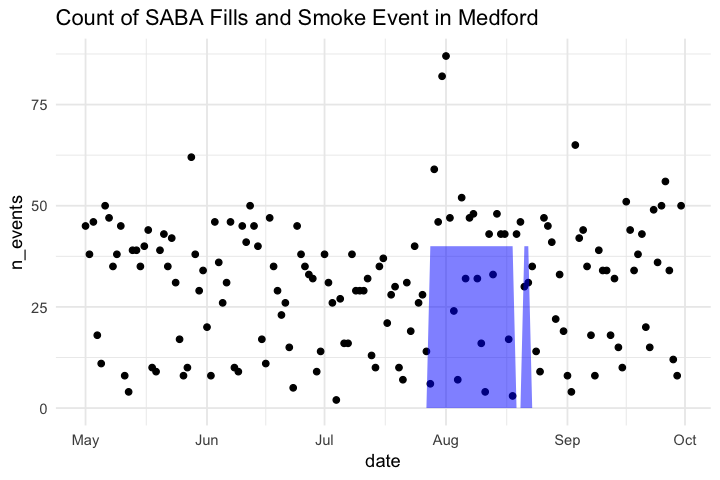

In [17]:
options(repr.plot.width = 6, repr.plot.height = 4)
# plot of counts
ggplot(saba_medford, aes(x=date, y = n_events)) +
    geom_point() + 
    geom_ribbon(aes(ymin = 0, ymax = smk10*40), fill = "blue", alpha = 0.5) +
    ggtitle("Count of SABA Fills and Smoke Event in Medford") +
    theme_minimal()

### Estimating Expected Counts of SABA Fills in Medford No Fire

In [18]:
# no smoke model
spl <- ns(saba_medford$date, df = 3)
nosmk_mod <- glm(n_events ~ weekend*spl, data = saba_medford, family = 'quasipoisson'(link='identity'))

In [19]:
nosmk_saba_pr <- predict(nosmk_mod, type = 'response', se.fit = TRUE, interval="prediction", level = 0.95)

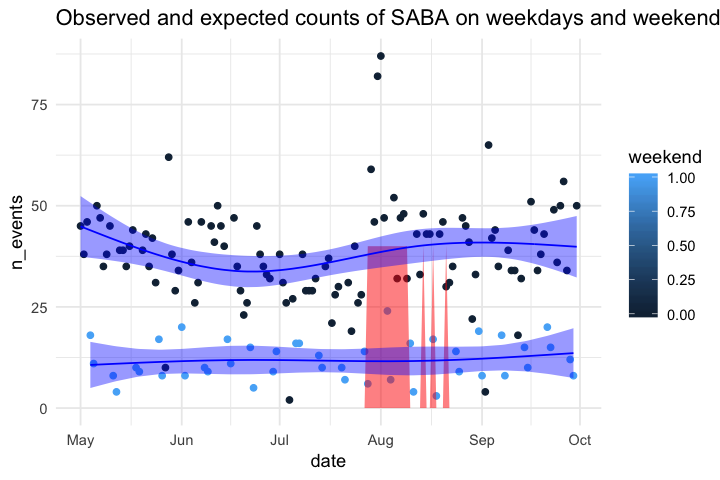

In [20]:
options(repr.plot.width = 6, repr.plot.height = 4)
# plot of counts no smoke
ggplot(saba_medford, aes(x=date, y = n_events)) +
    geom_point(aes(group=weekend, color = weekend)) +
    geom_ribbon(aes(ymin = 0, ymax = smk15*40), fill = "red", alpha = 0.5) +
    geom_line(aes(x=date, y=nosmk_saba_pr$fit, group = weekend), color = 'blue') +
    geom_ribbon(aes(ymin = (nosmk_saba_pr$fit - 1.96*nosmk_saba_pr$se.fit), 
                    ymax = (nosmk_saba_pr$fit + 1.96*nosmk_saba_pr$se.fit), 
                    group = weekend),
                    fill = "blue", alpha = 0.4) +
    ggtitle("Observed and expected counts of SABA on weekdays and weekends") +
    theme_minimal()

### Estimating Expected Counts of SABA Fills in Medford With Smoke

Now assuming that the spline x weekend interaction model does an adequate job predicting the background rate, I'll add in the binary smoke cutoff of > 15 ug/m<sup>3</sup>. The beta estimate for smoke should be the estimated average absolute difference on a smoke day during this time period. 

In [21]:
# estimating the effect of smoke 10 on counts
spl <- ns(saba_medford$date, df = 3)
smk_mod <- glm(n_events ~ smk15 + weekend*spl, data = saba_medford, family = 'quasipoisson'(link='identity'))

In [22]:
summary(smk_mod)


Call:
glm(formula = n_events ~ smk15 + weekend * spl, family = quasipoisson(link = "identity"), 
    data = saba_medford)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.1364  -0.9105  -0.0542   0.9921   5.4793  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   44.1508     3.5828  12.323  < 2e-16 ***
smk15         10.9829     2.9104   3.774 0.000234 ***
weekend      -34.0914     4.6631  -7.311 1.69e-11 ***
spl1          -5.7782     4.6639  -1.239 0.217389    
spl2         -15.2804     8.9383  -1.710 0.089504 .  
spl3           5.9719     3.7148   1.608 0.110109    
weekend:spl1   0.9911     5.7716   0.172 0.863901    
weekend:spl2  20.8369    11.7000   1.781 0.077032 .  
weekend:spl3  -2.9535     4.8551  -0.608 0.543925    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 2.923754)

    Null deviance: 1388.23  on 152  degrees of freedom
Residual devianc

## Relative Rate Results

Relative risk results for each binary smoke cutoff for each place of service. The general model has a 3 degree of freedom spline to account for seasonal trends and a weekend variable. Some models for the outcomes for office visits, SABA fills, and outpatient hospital admissions include and interaction between weekend and the seasonal spline.

These estimates will go in to the paper.

### Binary Smoke

In [23]:
# estimating the effect of smoke 10 on counts
spl <- ns(saba_medford$date, df = 3)
rel_smk_mod <- glm(n_events ~ smk15 + avg_temp + weekend + spl, data = saba_medford, family = 'quasipoisson'(link='log'))

In [24]:
summary(rel_smk_mod)


Call:
glm(formula = n_events ~ smk15 + avg_temp + weekend + spl, family = quasipoisson(link = "log"), 
    data = saba_medford)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.2664  -0.8610  -0.0689   1.0399   4.0063  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.759721   2.152117   4.535 1.19e-05 ***
smk15        0.353901   0.086125   4.109 6.59e-05 ***
avg_temp    -0.021078   0.007548  -2.793  0.00593 ** 
weekend     -1.152449   0.074884 -15.390  < 2e-16 ***
spl1         0.020481   0.154588   0.132  0.89478    
spl2        -0.208776   0.202430  -1.031  0.30408    
spl3         0.124602   0.084099   1.482  0.14060    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 2.588704)

    Null deviance: 1388.23  on 152  degrees of freedom
Residual deviance:  428.73  on 146  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


This model is straight-forward and robust. I find similar relative effects with other cutoffs. I would interpret this as on a given smoke day, SABA fill rates are 2 times higher in Medford compared to non-smoke days. Now the challenging part would be to try and quantify the health effects with confidence bounds attributed to this particular smoke event.

In [25]:
# subset to medford 
medford_df <- asthma_msa_ts %>% 
    # filter out ambulance visits
    filter(metroarea == 'Medford') %>% 
    filter(service_place != 'Ambulance-Land')

In [26]:
# finding the association in medford for the 3 levels of smoke for each outcome.
smoke_cut <- c('smk5', 'smk10', 'smk15')
# service place
pos <- unique(medford_df$service_place)

# create matrix of comparisons
compare_mat <- expand.grid(pos, smoke_cut) %>% 
    rename(pos = Var1, 
           smoke = Var2) %>% 
    # define spl + weekend vs interaction models
    mutate(formula = ifelse(pos %in% c('Office', 'SABA Fill', 'Outpatient Hospital'), 
                            paste0('n_events ~ ', smoke, ' + avg_temp + spl + weekend + log(offset(pop))'),
                            paste0('n_events ~ ', smoke, ' + avg_temp + spl + weekend + log(offset(pop))')
                           ))

In [27]:
# results
medford_bin_smk_results <- compare_mat %>%  
    # using apply; couldn't figure out map
    apply(., 1, function(x){
        # subset df
        df <- filter(medford_df, service_place == x[1])
        # fit spline
        spl <- ns(df$date, df = 3)
        # run model based on formula
        mod <- broom::tidy(glm(as.formula(x[3]), data = df, family = 'quasipoisson'(link='log'))) %>% 
            filter(term == x[2]) %>% 
            mutate(pos = x[1], 
                   smoke = x[2],
                   rel_rate = round(exp(estimate),3), 
                   lower95 = round(exp(estimate - (1.96*std.error)),3), 
                   upper95 = round(exp(estimate + (1.96*std.error)),3),
                   attrib_risk = round((((rel_rate - 1)/rel_rate)*100),1),
                   ar_lower95 = round((((lower95 - 1)/lower95)*100),1),
                   ar_upper95 = round((((upper95 - 1)/upper95)*100),1)) %>%
            select(pos, smoke, rel_rate, lower95, upper95, attrib_risk, ar_lower95, ar_upper95)
    }) %>% 
    # bind rows
    bind_rows()

In [28]:
# binary smoke results
medford_bin_smk_results

pos,smoke,rel_rate,lower95,upper95,attrib_risk,ar_lower95,ar_upper95
Emergency Department,smk5,0.986,0.617,1.577,-1.4,-62.1,36.6
Inpatient Hospital,smk5,0.930,0.693,1.248,-7.5,-44.3,19.9
Office,smk5,1.062,0.873,1.292,5.8,-14.5,22.6
Outpatient Hospital,smk5,0.812,0.573,1.148,-23.2,-74.5,12.9
SABA Fill,smk5,1.157,0.983,1.363,13.6,-1.7,26.6
Urgent Care,smk5,1.730,0.904,3.307,42.2,-10.6,69.8
Emergency Department,smk10,0.916,0.572,1.468,-9.2,-74.8,31.9
Inpatient Hospital,smk10,0.997,0.731,1.361,-0.3,-36.8,26.5
Office,smk10,1.318,1.060,1.639,24.1,5.7,39.0
Outpatient Hospital,smk10,0.881,0.604,1.286,-13.5,-65.6,22.2


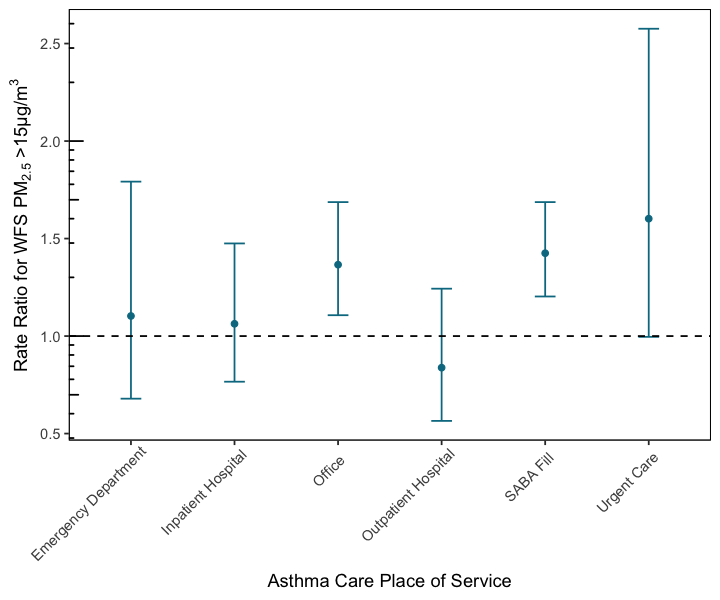

In [242]:
options(repr.plot.width = 6, repr.plot.height = 5)
# risk ratio plot of the > 15 ug/m^3
smk_rr_plot <- ggplot(filter(medford_bin_smk_results, smoke == 'smk15'), aes(x=pos, y=rel_rate, group = pos)) +
    geom_point(color = '#007991') + 
    geom_errorbar(aes(ymin=lower95, ymax=upper95), color = '#007991',width = 0.2) +
    geom_hline(yintercept = 1, linetype=2) +
    #scale_y_log10(breaks = c(0.5, 1, 2)) + #scales::log_breaks(n=10)) +
    annotation_logticks(sides = "l") +
    ylab(expression(paste("Rate Ratio for WFS PM"[2.5], " >15µg/m"^3))) +
    xlab('Asthma Care Place of Service') +
   # plot theme
    theme(panel.background = element_rect(fill = 'white', colour = 'black'),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    # strip element
    strip.background = element_rect(colour=NA, fill=NA),
    panel.border = element_rect(fill = NA, color = "black"),
    # facet text size
    strip.text = element_text(size = 10),
    # axis element (tilt)
    axis.text.x = element_text(angle = 45, hjust = 0.9, vjust = 0.7),
    #axis.title.x = element_blank(),
    #axis.ticks.x = element_blank(),
    axis.title.y = element_text(angle = 90))

smk_rr_plot

# save plot
ggsave("./Figs/medford_care_plot.tiff", smk_rr_plot, 
       units="in", width=6, height=5, dpi=300)

### Continuous Smoke

In [48]:
cont_smk_results <- medford_df %>% 
    mutate(avg_smk_pm10 = avg_smk_pm/10) %>% 
    split(.$service_place) %>% 
    map_dfr(function(x){ 
        # fit spline
        spl <- ns(x$date, df = 3)
        # extract place of service 
        outcome <- unique(x$service_place)
        # run model based on formula
        mod <- broom::tidy(glm(n_events ~ avg_smk_pm10 + avg_temp + 
                               spl + weekend, data = x, family = 'quasipoisson'(link='log'))) %>% 
            filter(term == 'avg_smk_pm10') %>% 
            mutate(pos = outcome, 
                   rel_rate = round(exp(estimate),3), 
                   lower95 = round(exp(estimate - (1.96*std.error)),3), 
                   upper95 = round(exp(estimate + (1.96*std.error)),3)) %>% 
            select(pos, term, rel_rate:upper95)
        })

In [49]:
cont_smk_results

pos,term,rel_rate,lower95,upper95
Emergency Department,avg_smk_pm10,1.010,0.958,1.065
Inpatient Hospital,avg_smk_pm10,0.991,0.956,1.029
Office,avg_smk_pm10,1.056,1.031,1.081
Outpatient Hospital,avg_smk_pm10,0.976,0.927,1.026
SABA Fill,avg_smk_pm10,1.055,1.036,1.075
Urgent Care,avg_smk_pm10,2.208,1.292,3.775


## Counterfactual Estimation of Smoke Impact

Identity link won't always work since it can lead to expected counts less than 0 in Poisson type models. I need to find a more robust way to do this. I have an idea using the log-link.

In [389]:
spl <- ns(saba_medford$date, df = 3)
smk_mod2 <- glm(n_events ~ smk15 + weekend*spl, data = saba_medford, family = 'quasipoisson'(link='log'))

In [390]:
# using a counterfactual approach to estimate the expected response over the period
saba_nosmk <- saba_medford %>% 
    mutate(smk15 = 0)

In [391]:
smk_pred <- predict(smk_mod2, newdata = saba_medford, type='response')

In [392]:
nosmk_pred <- predict(smk_mod2, newdata = saba_nosmk, type='response')

In [422]:
# assemble to plot
cfact_plot_df <- data.frame(saba_medford$date, saba_medford$n_events, smk_pred, nosmk_pred) %>% 
    rename(date = saba_medford.date, n_obs = saba_medford.n_events) %>% 
    gather(est, n_est, -date, -n_obs) %>% 
    mutate(est = factor(case_when(est == 'nosmk_pred' ~ 'No Smoke', 
                           est == 'smk_pred' ~ 'Smoke'), levels = c('Smoke', 'No Smoke')))

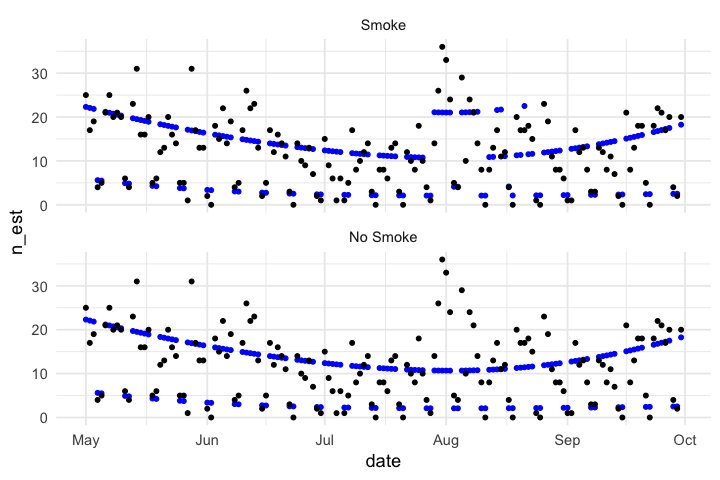

In [423]:
ggplot(cfact_plot_df, aes(x=date, y=n_est)) +
    geom_point(color = 'blue', size = 1) +
    geom_point(aes(x=date, y=n_obs), size = 1) +
    facet_wrap(~est, nrow = 2) +
    theme_minimal()

In [352]:
sum(smk_pred) - sum(nosmk_pred)

[1] 142.1954

## Discussion/Feedback

In our last meeting, Ander, Sheryl, and myself decided on an alternative strategy for trying to estimate the impact of the wildfire smoke event in Medford that took place over a couple weeks in 2013. Instead of a difference in difference  for monthly counts within each metroarea, we decided to use a Poisson model of daily counts, and evaluate the effect of a binary indicator of smoke exposure. Based on this model, we'd then estimate the impact of the smoke event in Medford using an HIA. I've sort of side stepped some parts of the HIA formula because it can be estimated from the model itself.

Below are a couple of issues I'd like to discuss to finalize this process.

1. Model family: I decided on quasi-Poisson to handle 0 values on days for some of the less common place of service like ED.

2. Binary smoke classifier of > 15 ug/m<sup>3</sup>: This has results in zero variance for other metroareas, hence I was not able to run an interaction model. I actually do not have a problem with this as it made the modeling simpler as I did not have to calculate differences of differences. That said, we could have just modeled Medford only. This leads in to a couple more considerations.

    a. Should I consider a different cutoff for the classifier? 
    
    b. Or do we want to approach this from a difference in difference model where I just code the time period of interest and contrasts the difference?


3. Given this time series approach, it seems like we could alternatively follow an HIA and use the beta from the conditional logistic regression model estimates and concentrations of smoke. Although, I like that this binary cutoff and time series is straight-forward.

4. Controlling for seasonal confounding: I have a very simple model adjusted for a couple things as a first step to figuring out the modeling approach. Should I consider adding a periodic function or a spline to try and estimate the number of events that would have occurred had the smoke not occurred? Right now, I use the seasonal average for Medford as the baseline rate. This could also possibly explain why I don't see anything with the less common events since I'm averaging over a possible seasonal dip?

5. This might be more of a question for Ander, but does this HIA/Monte Carlo approach work for you? I was not aware or could not figure out how to estimate a difference in the model directly, so I used pieces of information from it and a Monte Carlo to estimate the burden.